In [507]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

from wordcloud import WordCloud
from bidi.algorithm import get_display
import arabic_reshaper

from persian_wordcloud.wordcloud import PersianWordCloud

# Measuring Literature project

In [240]:
df = pd.read_excel("data/poems.xlsx", names=["Poet", "Poem", "Hemistich", "Verse","Text", "?"], index_col=0)
df.index.name="Index"
df.Text = df.Text.str.strip()
df.head(10)

,Poet,Poem,Hemistich,Verse,Text,?
Index,,,,,,
1,1,1,1,1,الا یا ایها الساقی ادر کاسا و ناولها,0
2,1,1,2,1,که عشق آسان نمود اول ولی افتاد مشکل‌ها,0
3,1,1,3,2,به بوی نافه‌ای کاخر صبا زان طره بگشاید,0
4,1,1,4,2,ز تاب جعد مشکینش چه خون افتاد در دل‌ها,0
5,1,1,5,3,مرا در منزل جانان چه امن عیش چون هر دم,0
6,1,1,6,3,جرس فریاد می‌دارد که بربندید محمل‌ها,0
7,1,1,7,4,به می سجاده رنگین کن گرت پیر مغان گوید,0
8,1,1,8,4,که سالک بی‌خبر نبود ز راه و رسم منزل‌ها,0
9,1,1,9,5,شب تاریک و بیم موج و گردابی چنین هایل,0


## Mapping the poets' id to names

In [241]:
poet={1:"Hafez", 2:"Saadi", 3:"Molavi", 4:"Attar", 5:"Sanaee", 6:"Vahshi", 7:"Khaghani", 8:"Anvari", 9:"Ouhadi", 10:"Khajoo",
      11:"Eraghi",12:"Razi", 13:"Hatef", 14:"Saeb Tabrizi", 15:"Kashani", 16:"Amir Khosro", 17:"Rahi",  18:"Shahriar",
      19:"Shah Nematollah", 20:"Seyf Farghani", 21:"Salman", 22:"Ghaani", 23:"Orfi", 24:"Obeyd", 25:"Helali",
      26:"Forooghi", 27:"Feyz", 28:"Bidel"}

# Exploratory analysis

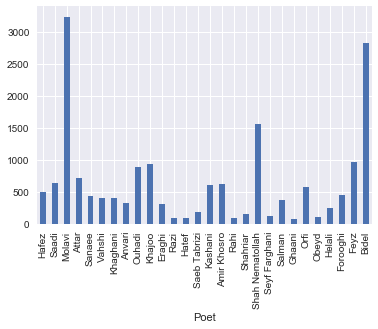

In [581]:
#Distribution of poems by poet
df_count_hemi = df[["Poet"]].groupby("Poet").size()
ax = df_count_hemi.plot("bar")
ax.set_xticklabels(list(poet.values()));

In [582]:
#length of hemistichs over the whole corpus
df.Text.apply(lambda x : len(x)).describe()

count    17905.000000
mean       581.107679
std        245.478889
min         39.000000
25%        427.000000
50%        550.000000
75%        715.000000
max       5992.000000
Name: Text, dtype: float64

C:\Users\Mathieu\Anaconda3\lib\site-packages\pandas\core\generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


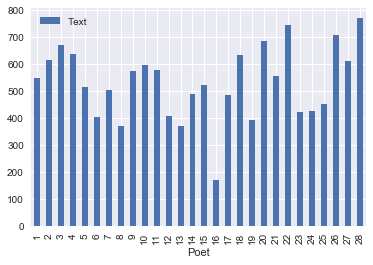

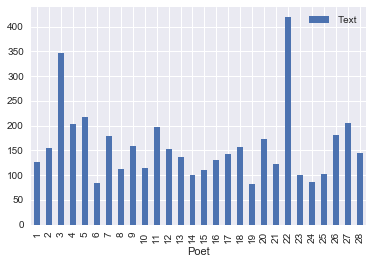

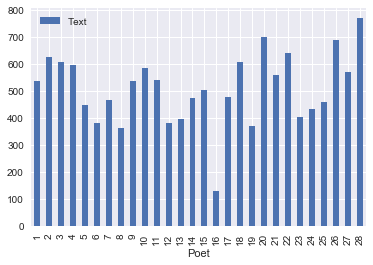

In [583]:
#length of hemistichs per author
length_per_author = df[["Poet","Text"]]
length_per_author.Text = length_per_author.Text.apply(lambda x : len(x))
length_per_author.groupby("Poet").mean().plot(kind="bar")
length_per_author.groupby("Poet").std().plot(kind="bar")
length_per_author.sort_values(["Text"],ascending=True).groupby("Poet").median().plot(kind="bar")

## Classification

In [245]:
# Use a subet
df_subset = df.sample(int(5*df.index.size/100))
df_copy = df.copy()

In [397]:
#df = df_subset
df = df_copy

In [398]:
#Group by beit or poem
df = df.groupby(["Poet","Poem"])['Text'].apply(' '.join).reset_index()

In [399]:
df_x = df.Text
df_y = df.Poet

In [568]:
with open("data\stopwords-fa.txt", 'r',  encoding='utf-8') as f:
    stopwords_fa = [line.strip() for line in f]

In [414]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
count_vect = CountVectorizer(stop_words=stopwords_fa)
df_x_counts = count_vect.fit_transform(df_x)
tfidf_transformer = TfidfTransformer()
df_x_tfidf = tfidf_transformer.fit_transform(df_x_counts)

In [ ]:
feature_names = count_vect.get_feature_names()

In [415]:
from sklearn.model_selection import train_test_split
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df_x_tfidf, df_y, test_size=.2, random_state = 0)

### Multinomial Naive Bayes classifier

In [403]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(df_x_train, df_y_train)

In [404]:
print(clf.score(df_x_test, df_y_test))

0.367495113097


First try not very good. Stopwords improve from 0.428 to 0.430

### Random Forest

In [416]:
#Weights
weights = dict()
for i in range(1,29) :
    weights[i] = df.loc[df.Poet == i].index.size/df.index.size

In [423]:
# TRAIN RANDOM FOREST

# Train model
rand_forest_model = sk.ensemble.RandomForestClassifier(n_estimators=100,max_depth=225, class_weight=weights)
rand_forest_model.fit(df_x_train_new,df_y_train)

# Predict
y_pred = rand_forest_model.predict(df_x_test_new)
y_pred_train = rand_forest_model.predict(df_x_train_new)

# Compute accuracy on training set
accuracy_rand_forest_training = sk.metrics.accuracy_score(df_y_train,y_pred_train)
print("Training accuracy score on training set")
print(accuracy_rand_forest_training)
print("Training precision score")
print(sk.metrics.precision_score(df_y_train,y_pred_train, average='micro'))

# Compute accuracy on test set
accuracy_rand_forest = sk.metrics.accuracy_score(df_y_test,y_pred)
print("Test accuracy score")
print(accuracy_rand_forest)
print("Test precision score")
print(sk.metrics.precision_score(df_y_test,y_pred, average='micro'))

# Confusion matrix
#print("Confusion matrix")
#cfm = sk.metrics.confusion_matrix(df_y_test,y_pred)
#print(cfm)

Training accuracy score on training set
0.999790561296
Training precision score
0.999790561296
Test accuracy score
0.682211672717
Test precision score
0.682211672717


In [258]:
max_depth_choices = [80, 100, 125, 150, 175, 200, 225, 250]
rf_scores = []
rf_param = []

#Loop for hyperparameter depth
for max_depth_choices_idx, max_depth_choices_value in enumerate(max_depth_choices):
    
    print('max_depth_choices_idx: ',max_depth_choices_idx+1,'/',len(max_depth_choices),', value: ',max_depth_choices_value)

    # Random forest
    rand_forest_model = sk.ensemble.RandomForestClassifier(n_estimators=100, max_depth=max_depth_choices_value,class_weight=weights)

    #Scores
    scores = cross_val_score(rand_forest_model, df_x_train, df_y_train, cv=num_folds, scoring='accuracy')
    rf_scores.append(scores.mean())
    rf_param.append(max_depth_choices_value)
    print('Accuracy = ', scores.mean())


max_depth_choices_idx:  1 / 8 , value:  80
Accuracy =  0.582028632568
max_depth_choices_idx:  2 / 8 , value:  100
Accuracy =  0.644183903483
max_depth_choices_idx:  3 / 8 , value:  125
Accuracy =  0.70331912749
max_depth_choices_idx:  4 / 8 , value:  150
Accuracy =  0.733108911715
max_depth_choices_idx:  5 / 8 , value:  175
Accuracy =  0.748753720498
max_depth_choices_idx:  6 / 8 , value:  200
Accuracy =  0.759199275117
max_depth_choices_idx:  7 / 8 , value:  225
Accuracy =  0.760076971564
max_depth_choices_idx:  8 / 8 , value:  250
Accuracy =  0.760882887482


best accuracy:
0.760882887482
best parameter:
250


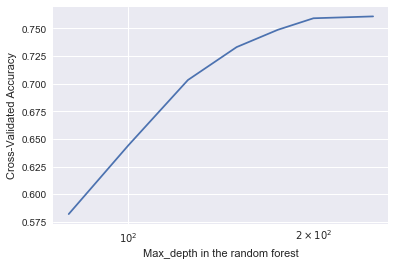

In [259]:
plt.semilogx(rf_param,rf_scores)
plt.xlabel('Max_depth in the random forest')
plt.ylabel('Cross-Validated Accuracy')

idx_best = np.argmax(rf_scores)
idx_worst = np.argmin(rf_scores)

print('best accuracy:')
print(np.max(rf_scores))
print('best parameter:')
best_param_depth = rf_param[idx_best]
worst_param_depth = rf_param[idx_worst]
print(best_param_depth)

In [557]:
importances = rand_forest_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rand_forest_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
important_indices=list()
important_features=list()

for f in range(460):
    #print("%d. feature %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))
    important_indices.append(importances[indices[f]])
    important_features.append(feature_names[indices[f]])
  
    
pd.DataFrame({"feature" : important_features, "importance" :important_indices}).head(20)
# Plot the feature importances of the forest
#plt.figure()
#plt.title("Feature importances")
#plt.bar(range(df_x_train.shape[1]), importances[indices],
#       color="r", yerr=std[indices], align="center")
#plt.xticks(range(1000), indices)
#plt.xlim([-1, 1000])
#plt.show()

,feature,importance
0,جان,0.034968
1,نعمت,0.027597
2,نفس,0.026124
3,رنگ,0.026101
4,آیینه,0.022946
5,ست,0.018713
6,الله,0.016787
7,محتشم,0.014720
8,اندر,0.013122
9,عرفی,0.012675


In [422]:
# Select features
select_features = sk.feature_selection.SelectFromModel(rand_forest_model,threshold=0.000152 , prefit=True)
df_x_train_new = select_features.transform(df_x_train)
df_x_test_new = select_features.transform(df_x_test)

In [438]:
len(select_features.get_support())
feature_names = [feature_names[x] for x in select_features.get_support(indices=True) if x]

<1x460 sparse matrix of type '<class 'numpy.float64'>'
	with 48 stored elements in Compressed Sparse Row format>

In [318]:
df_x_tfidf

<17905x68479 sparse matrix of type '<class 'numpy.float64'>'
	with 1155381 stored elements in Compressed Sparse Row format>

## Feature extraction

In [539]:
import sklearn.feature_extraction.text


class TextFeature(object):
    '''
    This class is to create feature matrix
    '''

    def __init__(self, corpus, analyzer='word', ngram=(1, 1), idf=False, norm=None, binary=False):
        tfm = sklearn.feature_extraction.text.TfidfVectorizer(use_idf=idf, analyzer=analyzer, tokenizer=str.split,
                                                              ngram_range=ngram, norm=norm,
                                                              stop_words=stopwords_fa, lowercase=False, binary=binary)
        self.tf_vec = tfm.fit_transform(corpus)
        self.feature_names = tfm.get_feature_names()

In [540]:
def poet_feature_extractor(df_x, df_y, column_label=1):
    '''
     Extract features based on label column
     :param column_label:
     :return:
     '''
    select_poet=dict()
    for i in range(1,29) :
        if i == column_label :
            select_poet[i] = 1
        else :
            select_poet[i] = 0
            
 
    df_y = df_y.map(select_poet)
    weights = {0 : (100*df_y.value_counts()[0]/df_y.size) , 1 : (100*df_y.value_counts()[1]/df_y.size)}
        
    feature_extractor = TextFeature(df_x)

    x = feature_extractor.tf_vec
    y = df_y

    rand_forest_model = sk.ensemble.RandomForestClassifier(n_estimators=100,max_depth=225, class_weight=weights)
    rand_forest_model.fit(x,y)
    
    # Select features
    #select_features = sk.feature_selection.SelectFromModel(rand_forest_model,threshold=0.000200 , prefit=True)
    #x_new = select_features.transform(x)
    #rand_forest_model.fit(x_new,y)
    #feature_names = [feature_extractor.feature_names[i] for i in select_features.get_support(indices=True) if i]
    
    #with open("data/output/features_importance_label_column_" + str(column_label) + ".csv", "w") as output:
    #    COLUMN_FEATURE = 'feature'
    #    COLUMN_IMPORTANCE = 'importance'
    #    fieldnames = [COLUMN_FEATURE, COLUMN_IMPORTANCE]
    #    writer = csv.DictWriter(output, fieldnames=fieldnames)

    #    writer.writeheader()
    #    for i in range(0, 500):
    #        writer.writerow({COLUMN_FEATURE: feature_extractor.feature_names[i].encode('utf-8'),
    #                         COLUMN_IMPORTANCE: rand_forest_model.feature_importances_[i]})

    importances = rand_forest_model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rand_forest_model.estimators_],
             axis=0)
    indices = np.argsort(importances)[::-1]
    important_indices=list()
    features=list()
    importance=list()
    tuples = dict()

    for f in range(500):
        #print("%d. feature %s (%f)" % (f + 1, feature_extractor.feature_names[indices[f]], importances[indices[f]]))
        features.append(feature_extractor.feature_names[indices[f]])
        importance.append(importances[indices[f]])
        tuples[get_display(arabic_reshaper.reshape((feature_extractor.feature_names[indices[f]])))] = importances[indices[f]]
    return tuples
        

In [541]:
#hafez = poet_feature_extractor(df.Text, df_y, 1)
bidel = poet_feature_extractor(df.Text, df_y, 28)
#poet_features = pd.DataFrame()
#for i in range (1,29) :
#    poet_features[i] = poet_feature_extractor(df.Text, df_y, i)

In [542]:
hafez

{'ﮎﺎﺧ': 0.0010592514142797476,
 'ﮎﺮﺗ': 0.00050298231920562831,
 'ﮎﺮﺗﺭﻭﺩ': 0.00061866625366114171,
 'ﮏﺷﺍ': 0.00060522242710474739,
 'ﮏﻠﻓ': 0.00070712633214913359,
 'ﮏﻣﺎﯿﺳ': 0.00052754584454805847,
 'ﮓﻧﺭ': 0.00040310871241718395,
 'ﮓﻧﺮﯿﻧﺮﭘ': 0.00044816692244535822,
 'ﮓﻨﭼ': 0.00063915428587933535,
 'ﮓﻨﺗ': 0.00048979625890100081,
 'ﯼﺍﯽﻣ': 0.00049278858514243936,
 'ﯼﺍﺪﺧ': 0.00042730548360202063,
 'ﯼﺍﻩﻮﺸﻋ': 0.00046614253183795899,
 'ﯼﺍﻪﭽﺒﻐﻣ': 0.00042199443133428131,
 'ﯼﺍﻪﺘﺧﺍﺩﺮﭙﻧ': 0.00044218388168530958,
 'ﯼﺍﻪﺤﻔﻧ': 0.00068977111233684951,
 'ﯼﺍﻪﻣﺎﻤﺷ': 0.00045541238571634025,
 'ﯼﺎﺳﺮﻄﻋ': 0.00091069203188700568,
 'ﯼﺎﺸﮕﺑ': 0.00041386478005304755,
 'ﯼﺎﻫﯼﺪﻧﺭ': 0.00044425992181152334,
 'ﯼﺎﻫﻝﺰﻏ': 0.00094545541319091941,
 'ﯼﺪﻧﺭ': 0.00079788796027048471,
 'ﯼﺪﻨﻗﺮﻤﺳ': 0.00050574776113840249,
 'ﯼﺭﺍﺩﯽﻣ': 0.00070908133806866212,
 'ﯼﺭﺍﺩﺍﻮﻫ': 0.0004429904901053435,
 'ﯼﺭﺍﺪﻧﺎﯿﻣ': 0.00049118330125376669,
 'ﯼﺭﺍﺬﮔ': 0.00047253536618488867,
 'ﯼﺮﻈﻧ': 0.00041007351457393734,
 'ﯼﺮﻫﺍﻮﺠﻟﺍ': 0.00051207328322722514,
 'ﯼﺯﺎ

### Word clouds

In [573]:
all_text = " "
for row in df.Text :
    all_text = all_text + row
#for word in list(all_text):
#    if word in stopwords_fa:
#        all_text.replace(word, '')

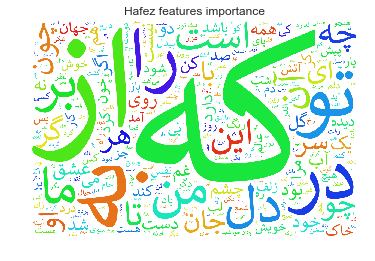

In [574]:

wc = WordCloud(background_color="white", max_words=300, mask=None, stopwords=None, margin=10, width = 1200, height = 800,
               random_state=1, font_path= "C:\Windows\Fonts\calibri.ttf").generate(get_display(arabic_reshaper.reshape(all_text)))

def display_cloud(wc) :
    default_colors = wc.to_array()
    plt.figure()
    plt.title("Hafez features importance")
    plt.imshow(default_colors)
    plt.axis("off")
    plt.show()
    return

display_cloud(wc)
image = wc.to_image()
image.save('bidel.png')

In [570]:
stopwords_fa

['!',
 ',',
 '.',
 ':',
 ';',
 '،',
 '؛',
 '؟',
 'بیدل',
 'شمس',
 'سعدیا',
 'سعدیست',
 'سید',
 'فیض',
 'حافظ',
 'حافظا',
 'تبریز',
 'خواجو',
 'اوحدی',
 'عطار',
 'سعدی',
 'تبریزی',
 'آباد',
 'رهی',
 'آ',
 'عراقی ره',
 'قاآنی',
 'آری',
 'ز',
 'عراقی،',
 'قاآنیم',
 'قاآنیا',
 'آمد',
 'ز',
 'گر',
 'آمده',
 'آن',
 'آنان',
 'آنجا',
 'آنطور',
 'آنقدر',
 'آنكه',
 'آنها',
 'آنچه',
 'آنکه',
 'آورد',
 'آورده',
 'آيد',
 'آی',
 'آیا',
 'آیند',
 'اتفاقا',
 'اثرِ',
 'احتراما',
 'احتمالا',
 'اخیر',
 'اری',
 'از',
 'ازجمله',
 'اساسا',
 'است',
 'استفاد',
 'استفاده',
 'اش',
 'اشکارا',
 'اصلا',
 'اصولا',
 'اعلام',
 'اغلب',
 'اكنون',
 'الان',
 'البته',
 'البتّه',
 'ام',
 'اما',
 'امروز',
 'امروزه',
 'امسال',
 'امشب',
 'امور',
 'ان',
 'انجام',
 'اند',
 'انشاالله',
 'انصافا',
 'انطور',
 'انقدر',
 'انها',
 'انچنان',
 'انکه',
 'انگار',
 'او',
 'اول',
 'اولا',
 'اي',
 'ايشان',
 'ايم',
 'اين',
 'اينكه',
 'اکثرا',
 'اکنون',
 'اگر',
 'ای',
 'ایا',
 'اید',
 'ایشان',
 'ایم',
 'این',
 'اینجا',
 'ایند',
 'اینطور',
 'ا